In [1]:
#Fast LSTM backed by CuDNN
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D,BatchNormalization, LSTM, CuDNNLSTM, MaxPooling2D
from keras.models import Sequential
from keras import regularizers
import keras

from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import matplotlib.pyplot as plt
import cv2




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        '/content/drive/MyDrive/Yoga Dataset 1/TRAIN',
        target_size=(224, 224),
        batch_size=16,
#         color_mode="RGB",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        '/content/drive/MyDrive/Yoga Dataset 1/TEST',
        target_size=(224, 224),
        batch_size=16,
#         color_mode="RGB",
        class_mode='categorical')

Found 1086 images belonging to 5 classes.
Found 484 images belonging to 5 classes.


In [4]:
dim = (224,224) # for MobileNetV2
n_sequence = 8 # for LSTM
n_channels = 3 # color channel(RGB)
n_output = 5 #18 # number of output class

In [5]:
model = Sequential()    
model.add(tf.keras.layers.Reshape((1, 224, 224, 3), input_shape=(224, 224, 3)))
model.add( 
    TimeDistributed(
        MobileNetV2(weights='imagenet',include_top=False), 
        input_shape=(n_sequence, *dim, n_channels)
    )
)
model.add(
    TimeDistributed(
        GlobalAveragePooling2D()
    )
)
model.add(CuDNNLSTM(128,return_sequences = True))
model.add(Dropout(0.2))

model.add(CuDNNLSTM(128))
model.add(Dropout(0.2))

model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(5,activation = 'softmax'))

cv2.ocl.setUseOpenCL(False)




9420800/9406464 [==============================] - 0s 0us/step


In [7]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])
epochs = 7 
batch_size = 16

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 224, 224, 3)    0         
                                                                 
 time_distributed (TimeDistr  (None, 1, 7, 7, 1280)    2257984   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 1280)          0         
 tributed)                                                       
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 1, 128)            721920    
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 128)               1

In [9]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
history = model.fit(train_generator, epochs = epochs,validation_data = validation_generator)

Epoch 1/7


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


68/68 [==============================] - ETA: 0s - loss: 1.5090 - accuracy: 0.4162

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


68/68 [==============================] - 442s 6s/step - loss: 1.5090 - accuracy: 0.4162 - val_loss: 1.1726 - val_accuracy: 0.7500
Epoch 2/7
68/68 [==============================] - 33s 493ms/step - loss: 0.9274 - accuracy: 0.7974 - val_loss: 0.4860 - val_accuracy: 0.9401
Epoch 3/7
68/68 [==============================] - 33s 492ms/step - loss: 0.4305 - accuracy: 0.9411 - val_loss: 0.2509 - val_accuracy: 0.9628
Epoch 4/7
68/68 [==============================] - 34s 492ms/step - loss: 0.2059 - accuracy: 0.9788 - val_loss: 0.1496 - val_accuracy: 0.9711
Epoch 5/7
68/68 [==============================] - 34s 501ms/step - loss: 0.1272 - accuracy: 0.9862 - val_loss: 0.1353 - val_accuracy: 0.9628
Epoch 6/7
68/68 [==============================] - 34s 495ms/step - loss: 0.0871 - accuracy: 0.9908 - val_loss: 0.1075 - val_accuracy: 0.9731
Epoch 7/7
68/68 [==============================] - 33s 495ms/step - loss: 0.1028 - accuracy: 0.9843 - val_loss: 0.1714 - val_accuracy: 0.9504


In [11]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 8/31 [======>.......................] - ETA: 8s - loss: 0.2643 - accuracy: 0.9297

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


31/31 [==============================] - 13s 430ms/step - loss: 0.1714 - accuracy: 0.9504
final train accuracy = 96.50 , validation accuracy = 95.04


In [12]:
model.save('YogaNet_model_1_1.h5')

In [29]:
import numpy as np
from PIL import Image
from keras.preprocessing import image

from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
model = load_model('YogaNet_model_1_1.h5')
img = image.load_img('/content/drive/MyDrive/Yoga Dataset 1/TEST/warrior2/00000000.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
print(classes) 

[[0.00146739 0.00670522 0.01378938 0.00289364 0.9751443 ]]


In [19]:
hist = history.history

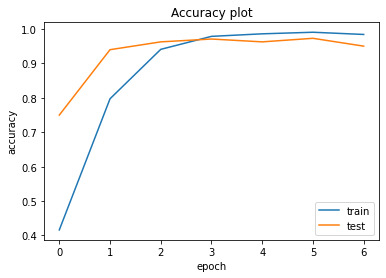

In [21]:
hist = history.history
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("mobilenetCuDNNLSTMv3_accuracy.png")

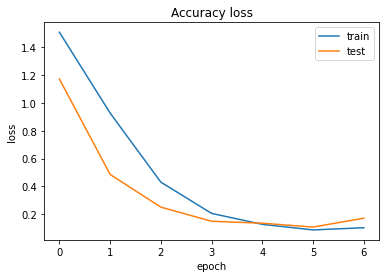

In [22]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("mobilenetCuDNNLSTMv3_loss.png")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


              precision    recall  f1-score   support

     downdog       0.20      0.21      0.20        97
     goddess       0.17      0.13      0.15        82
       plank       0.23      0.23      0.23       115
        tree       0.17      0.19      0.18        78
    warrior2       0.27      0.29      0.28       112

    accuracy                           0.21       484
   macro avg       0.21      0.21      0.21       484
weighted avg       0.21      0.21      0.21       484



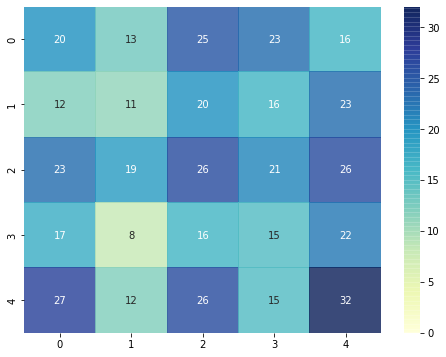

In [23]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
predictions = model.predict_generator(validation_generator)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())   
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(confusion_matrix(true_classes, predicted_classes)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

In [30]:
label = np.argmax(classes)
print(label)

4


In [38]:
if label==0:
  {
    print("The Input image belongs to DownDog Yoga Pose")
  }

elif label==1:
  {
    print("The Input image belongs to Goddess Yoga Pose")   
  }

elif label==2:
  {
    print("The Input image belongs to Plank Yoga Pose")   
  }

elif label==3:
  {
    print("The Input image belongs to Tree Yoga Pose")   
  }

elif label==4:
  {
    print("The Input image belongs to WarriorII Yoga Pose")   
  }

else:
  print("Unkown Pose")


The Input image belongs to WarriorII Yoga Pose
